# [20250404] Pytorch Tutorial

- learn basic pytorch

In [33]:
import torch
import numpy as np

In [34]:
data = [[1, 2], [3, 4]]
print(f'data({type(data)}: {data})')

tensor_data = torch.tensor(data)
print(f'tensor_data({type(tensor_data)}: {tensor_data})')

data(<class 'list'>: [[1, 2], [3, 4]])
tensor_data(<class 'torch.Tensor'>: tensor([[1, 2],
        [3, 4]]))


In [35]:
np_array = np.array(data)
print(f'np_array({type(np_array)}: {np_array})')

np_tensor = torch.from_numpy(np_array)
print(f'np_tensor({type(np_tensor)}: {np_tensor})')

np_array(<class 'numpy.ndarray'>: [[1 2]
 [3 4]])
np_tensor(<class 'torch.Tensor'>: tensor([[1, 2],
        [3, 4]]))


In [36]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [37]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

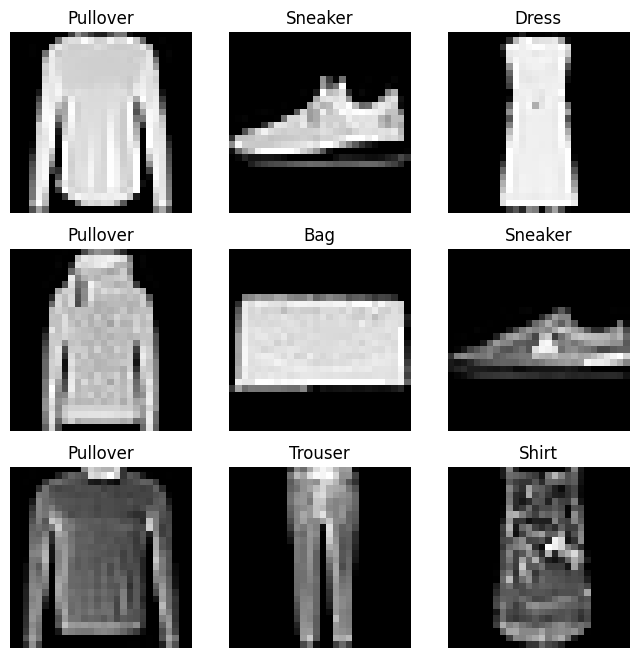

In [38]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  plt.subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')


In [39]:
tensor_x = torch.randint(len(training_data), size=(1,))
x = tensor_x.item() # Tensor.item() only works for tensors with one element.

print(f'tensor_x: {tensor_x}, x: {x}')

tensor_x: tensor([2565]), x: 2565


In [40]:
from torchvision.transforms import ToTensor, Lambda

In [41]:
ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

without squeeze: torch.Size([1, 28, 28])
with squeeze: torch.Size([28, 28])


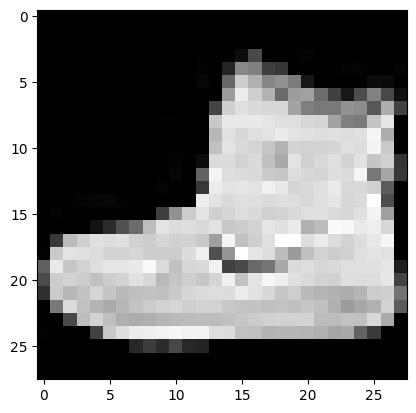

In [42]:
print(f'without squeeze: {ds[0][0].shape}')

print(f'with squeeze: {ds[0][0].squeeze().shape}')

plt.imshow(ds[0][0].squeeze(), cmap='gray')

In [43]:
from torch import nn

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} device')

Using cuda device


In [45]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [46]:
model = NeuralNetwork().to(device)

In [47]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [48]:
X, y = ds[0]
X = X.to(device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"True class: {torch.argmax(y)}, Predicted class: {y_pred}")

True class: 9, Predicted class: tensor([1], device='cuda:0')


In [49]:
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [50]:
loss.backward()

In [51]:
print(w.grad)
print(b.grad)

tensor([[0.0662, 0.2167, 0.0525],
        [0.0662, 0.2167, 0.0525],
        [0.0662, 0.2167, 0.0525],
        [0.0662, 0.2167, 0.0525],
        [0.0662, 0.2167, 0.0525]])
tensor([0.0662, 0.2167, 0.0525])


In [52]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [53]:
loss_fn = nn.CrossEntropyLoss()

In [54]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [59]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * batch_size + len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [62]:
def test_loop(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [63]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [64]:
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loop(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.176803  [   64/60000]
loss: 2.160348  [ 6464/60000]
loss: 2.107505  [12864/60000]
loss: 2.118595  [19264/60000]
loss: 2.069200  [25664/60000]
loss: 2.008781  [32064/60000]
loss: 2.037468  [38464/60000]
loss: 1.963600  [44864/60000]
loss: 1.970178  [51264/60000]
loss: 1.892421  [57664/60000]
Test Error: 
 Accuracy: 49.9%, Avg loss: 1.890067 

Epoch 2
-------------------------------
loss: 1.929610  [   64/60000]
loss: 1.894424  [ 6464/60000]
loss: 1.782050  [12864/60000]
loss: 1.820306  [19264/60000]
loss: 1.718007  [25664/60000]
loss: 1.659225  [32064/60000]
loss: 1.684899  [38464/60000]
loss: 1.586885  [44864/60000]
loss: 1.609087  [51264/60000]
loss: 1.505912  [57664/60000]
Test Error: 
 Accuracy: 60.5%, Avg loss: 1.517169 

Epoch 3
-------------------------------
loss: 1.585887  [   64/60000]
loss: 1.547315  [ 6464/60000]
loss: 1.400031  [12864/60000]
loss: 1.473056  [19264/60000]
loss: 1.358242  [25664/60000]
loss: 1.340963  [32064/600

In [65]:
import torchvision.models as models

In [66]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.7MB/s]


In [67]:
model_no_train = models.vgg16()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [68]:
torch.save(model, 'model.pth')

In [70]:
model_complete = torch.load('model.pth', weights_only=False)

In [71]:
model_complete.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1